In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import math
import pandas as pd
import xgboost
#import lightgbm
import catboost

from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr
from itertools import combinations
from sklearn.base import BaseEstimator
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              VotingClassifier)
from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [2]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Bias-variance trade-off

**2 балла**

Продемонстрируйте bias-variance trade-off для `DecisionTreeRegressor` при изменении глубины дерева. Постройте регрессионную модель функции от одной независимой переменной, представленной в ячейке ниже, используя функцию `plot_regression_predictions` (можете ее как-то поменять, если захочется). Попробуйте разные значения глубины деревьев, при каком значении, на ваш взгляд, модель оптимальна, при каком variance становится слишком большим?

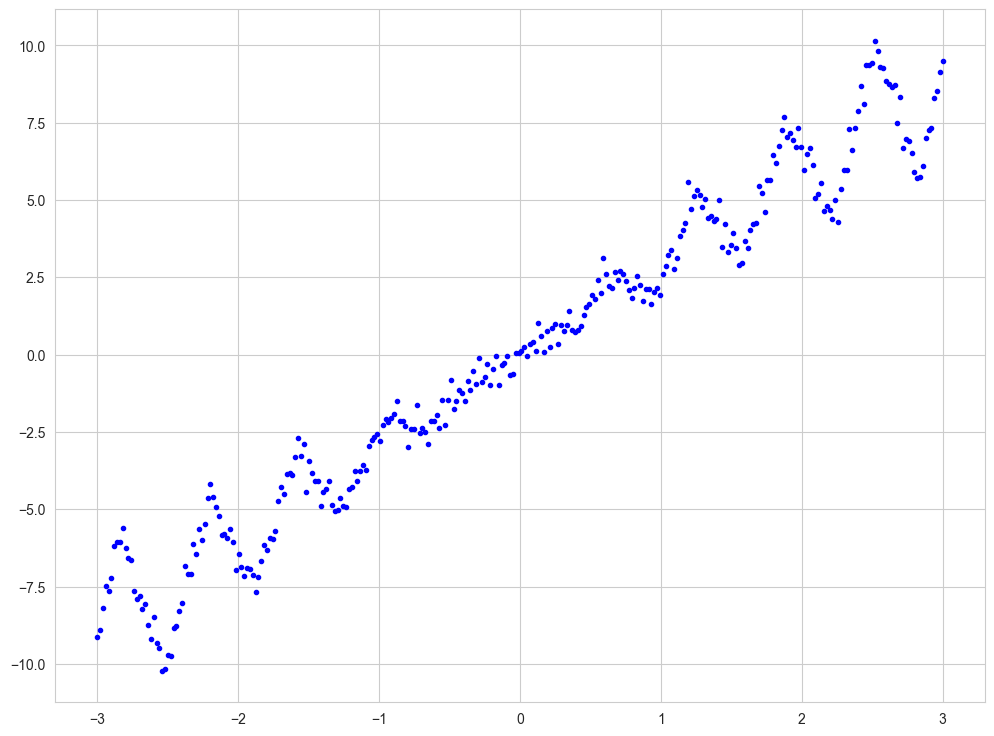

In [3]:
# Сгенерируем какую-нибудь необычную зависимость и научимся ее предсказывать
np.random.seed(42)
m = 300
X = np.linspace(-3, 3, m).reshape(-1, 1)
y = (3 + 2/np.pi * np.arcsin(np.cos(10 * X))) * X
y = y + np.random.randn(m, 1) / 3
plt.plot(X.reshape(-1), y.reshape(-1), "b.");

In [4]:
# Функция для отрисовки предсказаний деревьев решений в случае регрессии
def plot_regression_predictions(X, y, max_depth, axes=[-3, 3, -10, 10], ylabel="$y$"):
    tree_reg = DecisionTreeRegressor(max_depth = max_depth) # Add classifier
    tree_reg.fit(X, y) # Add fit 
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    colors = ['red', 'blue', 'green', 'orange']
    plt.plot(x1, y_pred, linewidth=2, label=r"$\hat{y}$", color=colors[np.random.randint(0,4)])

Изобразите, как меняются предсказания дерева при увеличении максимальной глубины (можно взять что-то в диапазоне от 1 до 15):

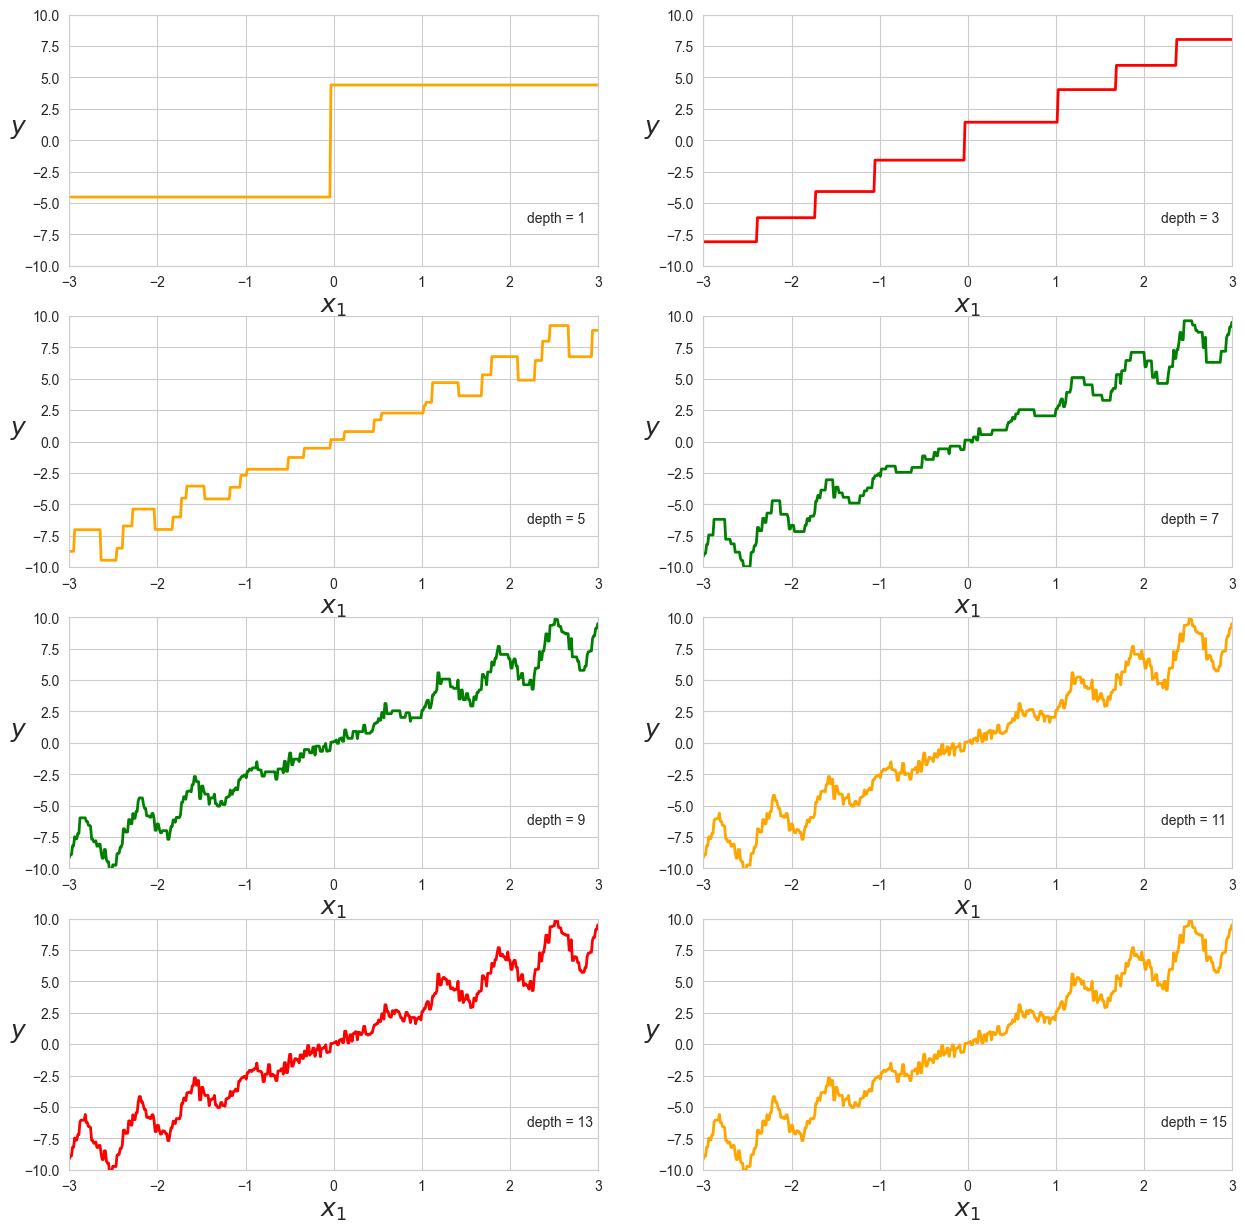

In [5]:
plt.figure(figsize=(15,15))

depth_steps = [1,3,5,7,9,11,13,15]
for i, depth in enumerate(depth_steps):
    plt.subplot(4, 2, i+1)
    plot_regression_predictions(X, y, max_depth=depth)
    plt.text(2.2, -6.5, s=f'depth = {depth}')

At the smallets steps, the **bias** is very high. At step 5 or 7, there is the optimal model, while with further increase of steps the variance increase and model overfits the data

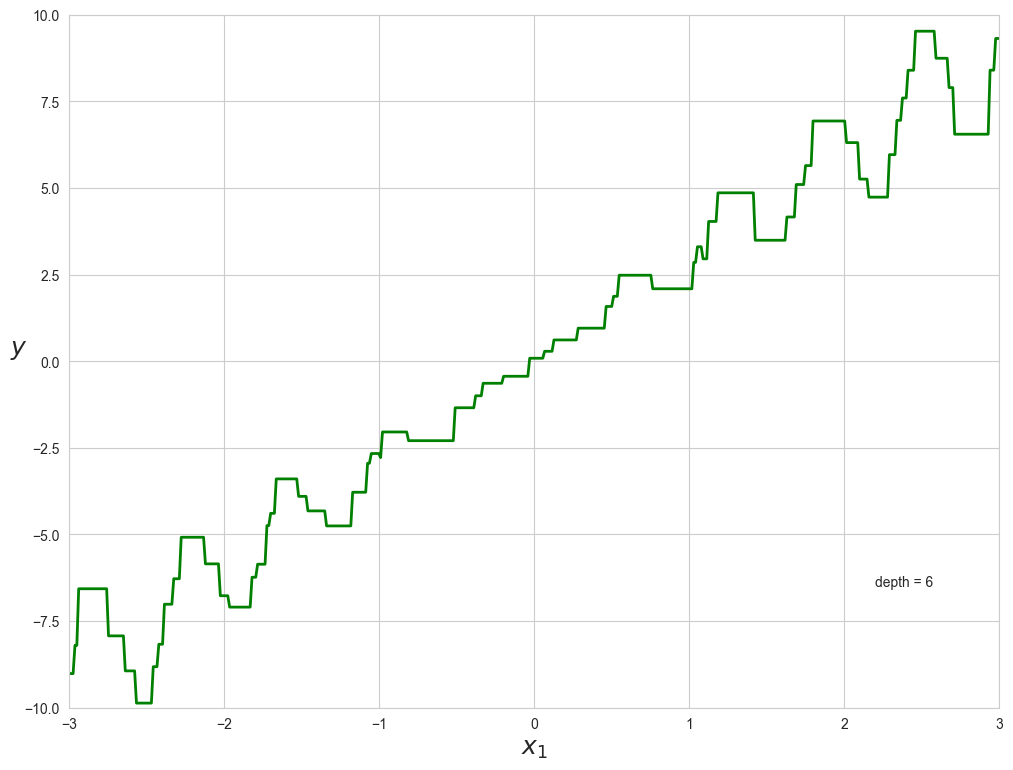

In [6]:
plot_regression_predictions(X, y, max_depth=6)
plt.text(2.2, -6.5, s=f'depth = {6}');

Previously I used odd numbers for steps. Here is the model with max_depth = 6 which seems to be the most optimal among all variants.

### Задание 2. Random forest

Теперь давайте немного подготовимся к тому, чтобы реализовать свой собственный случайный лес, а потом реализуем его.

#### Задание 2. 1. Простое ансамблирование

**1 балла**

Представим, что у нас есть 101 классификатор. Каждый может с вероятностью `p` (равной для всех моделей) правильно предсказать класс объекта. Будем делать предсказания по большинству голосов (majority vote). Постройте зависимость вероятности правильно классифицировать объект от значения `p`. Вам может быть полезная следующая формула:

$$ \large \mu = \sum_ {i = 51} ^ {101} C_{101} ^ ip ^ i (1-p) ^ {101-i} $$

In [7]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

А теперь давайте посмотрим на другую ситуацию. У нас есть фиксированная вероятность того, что модель правильно классифицирует объект `p = 0.65`. Постройте зависимость вероятности правильно классифицировать объект от числа моделей в ансамбле.

In [8]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

Опишите ваши наблюдения:

* ...
* ...

#### Задание 2. 2. Реализация простого RF

**4 балла**

Реализуйте свой собственный класс `RandomForestClassifierCustom`, используя в качестве базовой модели `DecisionTreeClassifier` из `sklearn`.

Небольшое описание:
- Используйте приведенный ниже код
- В методе `fit` в цикле (`i` от 0 до `n_estimators-1`):
    * Зафиксируйте генератор случайных чисел следующим образом np.random.seed(`random_state + i`). Идея в том, что на каждой итерации у нас будет новое значение для генератора случайных чисел, что добавит побольше "случайности", но в то же время мы сможем иметь воспроизводимые результаты
    * После чего выберите `max_features` признаков **без возвращения/without replacement**, сохраните список выбранных признаков (их индексов) в `self.feat_ids_by_tree`
    * Также создайте псевдовыборку при помощи бутстрэпа (выбор **с возвращением/with replacement**) из тренировочных данных. Может помочь функция `np.random.choice` и ее аргумент `replace`
    * Обучите дерево решений с параметрами, заданными в конструкторе класса `max_depth`, `max_features` и `random_state` на полученной псевдовыборке.
- Метод `fit` должен возвращать текущий экземпляр класса `RandomForestClassifierCustom`, то есть `self` (все по-взрослому, как в `sklearn`)
- В методе `predict_proba` мы должны пройти циклом по всем деревьям. Для каждого предсказания, нам нужно будет брать только те признаки, на которых училось изначальное дерево, поэтому мы и сохраняли эту информацию в артрибуте `self.feat_ids_by_tree`. Этот метод должен возвращать предсказанные вероятности (можно делать двумя способами: для каждого дерева предсказывать значение при помощи метода `predict_proba` и потом усреднять эти вероятности, или к примеру пользоваться методом `predict` и также считать среднее.

In [9]:
class RandomForestClassifierCustom(BaseEstimator):
    def __init__(
        self, n_estimators=10, max_depth=None, max_features=None, random_state=SEED
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state

        self.trees = []
        self.feat_ids_by_tree = []

    def fit(self, X, y):
        self.classes_ = sorted(np.unique(y))
        
        for i in range(0, self.n_estimators):
            np.random.seed(SEED + i)
            feature_idx = np.array(np.random.choice(X.shape[1], self.max_features, replace = False))
            self.feat_ids_by_tree.append(feature_idx)
            bootstrapped_idx = np.array(np.random.choice(X.shape[0], X.shape[0], replace=True))
            bootstrapped_X = np.array([X[i] for i in bootstrapped_idx])
            bootstrapped_X_with_selected_features = np.array([bootstrapped_X[:, k] for k in self.feat_ids_by_tree[i]]).T
            bootstrapped_y = np.array([y[i] for i in bootstrapped_idx])
            current_tree_model = DecisionTreeClassifier(max_depth=self.max_depth, random_state=self.random_state)
            current_tree = current_tree_model.fit(bootstrapped_X_with_selected_features, bootstrapped_y)
            self.trees.append(current_tree)
        return self

    def predict_proba(self, X):
        total_pred = []
        for i in range(len(self.trees)):
            y_pred = self.trees[i].predict_proba(np.array([X[:, k] for k in self.feat_ids_by_tree[i]]).T)
            total_pred.append(y_pred)
        return np.mean(total_pred, axis = 0)

    def predict(self, X):
        probas = self.predict_proba(X)
        predictions = np.argmax(probas, axis=1)
        
        return predictions

Протестируем нашу реализацию на искусственных данных. Визуализируйте разделяющую границу, которую рисует ваша модель при помощи функции `plot_decision_boundary` (см. примеры в лекции).

In [10]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#ffdab9","#9898ff", "#4B0082"])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#ffdab9", "#4c4c7f", "#4B0082"])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

In [11]:
X, y = datasets.make_moons(n_samples=500, noise=0.30, random_state=SEED)

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.25,
                                                    random_state=SEED,
                                                    stratify=y)

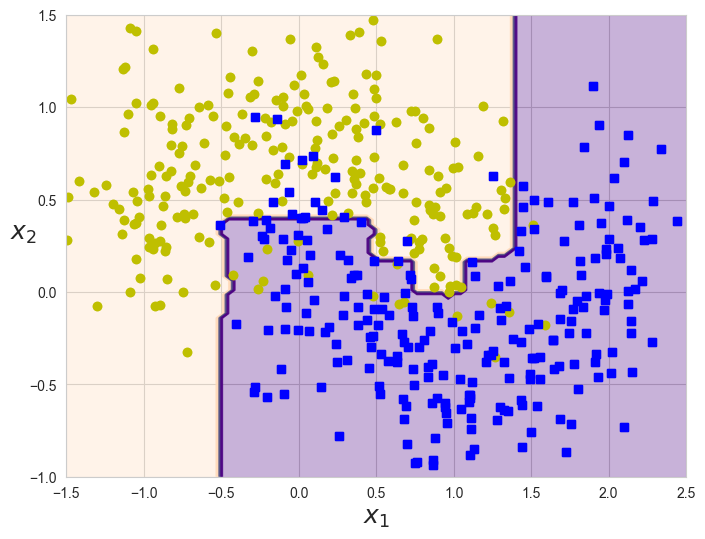

In [12]:
plt.figure(figsize=(8, 6))

clf = RandomForestClassifierCustom(n_estimators=500, max_depth=5, max_features=2, random_state=SEED)
clf.fit(X_train, y_train)

plot_decision_boundary(clf, X, y)

plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.show()


It would be very hard to analyse all images, so cross-validation is better way to solve this task.

In [13]:
clf = RandomForestClassifierCustom(max_features=2, random_state=SEED)

parapaparams = {'max_depth': list(range(3, 15, 2)),
                'n_estimators': [50, 100, 200, 300, 400, 500, 700, 900]}

grid_search = GridSearchCV(estimator = clf, param_grid = parapaparams, cv=5, scoring = 'f1_macro')

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifierCustom(max_features=2),
             param_grid={'max_depth': [3, 5, 7, 9, 11, 13],
                         'n_estimators': [50, 100, 200, 300, 400, 500, 700,
                                          900]},
             scoring='f1_macro')

In [14]:
grid_search.best_params_

{'max_depth': 7, 'n_estimators': 700}

Accroding to grid search with cross-validation, these parameters are the best. Let's draw this model

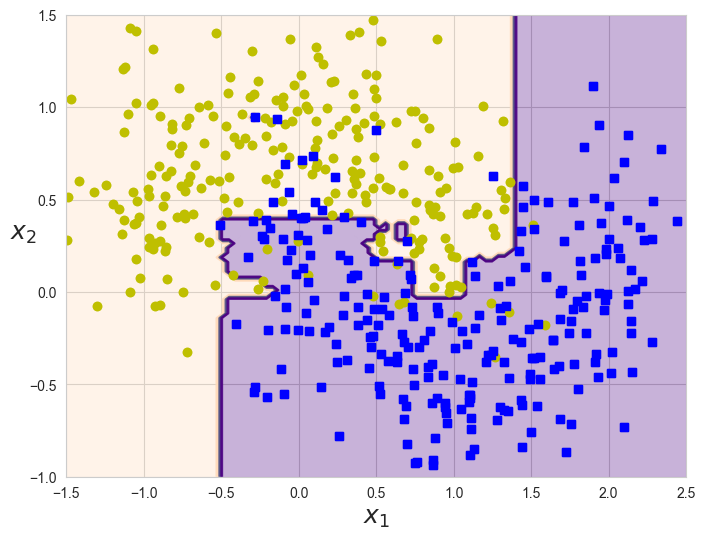

In [15]:
plt.figure(figsize=(8, 6))

clf = RandomForestClassifierCustom(n_estimators=700, max_depth=7, max_features=2, random_state=SEED)
clf.fit(X_train, y_train)

plot_decision_boundary(clf, X, y)

plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.show()

Actually, the border seems to be very goos.

Подберите наилучшие гиперпараметры, при которых разделяющая граница будет, на ваш взгляд, оптимальной с точки зрения bias-variance. Можно также подключить какие-то метрики для выбора лучшей модели.

#### Задание 2. 3. Корреляция базовых моделей

**3 балла**

Как мы выянили на лекции, для того, чтобы bagging работал хорошо, предсказания наших моделей не должны сильно коррелировать. Для этого в случайном лесе применяются различные подходы, в том числе и RSM. Давайте посмотрим, как влияет параметр `max_features` на корреляцию базовых моделей в случайном лесу из `sklearn`. В качестве примера будем использовать датасет `breast_cancer`. Для расчета корреляций используйте приведенную ниже функцию `base_model_pair_correlation`. Для каждой модели у вас будет получаться набор значений (попарные корреляции всех деревьев), дальше можно изобразить их в виде боксплотов, как мы на лекции рисовали распределение метрик.

In [16]:
# Функция для расчета попарных корреляций базовых моделей в случайном лесу
def base_model_pair_correlation(ensemble, X):
    corrs = []
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        ypred_t2 = est2.predict_proba(Xj_test)[:, 1]

        corrs.append(pearsonr(ypred_t1, ypred_t2)[0])
    return np.array(corrs)

In [17]:
# Загрузим данные
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Firstly we have to look at our data

In [18]:
X.shape, y.shape

((569, 30), (569,))

We have 30 features in our data

In [19]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [20]:
clf = RandomForestClassifier(max_features=5)
clf.fit(X_train, y_train)

RandomForestClassifier(max_features=5)

In [21]:
max_features= [3,5,7,9,11,15,17,21,23,27,29]

In [22]:
max_features_data = []
for max_feature in max_features:
    clf = RandomForestClassifier(max_features=max_feature, n_estimators=100, random_state=SEED)
    clf.fit(X_train, y_train)
    corrs = pd.DataFrame(base_model_pair_correlation(clf, X_test), columns=[f'{max_feature}'])
    max_features_data.append(corrs)

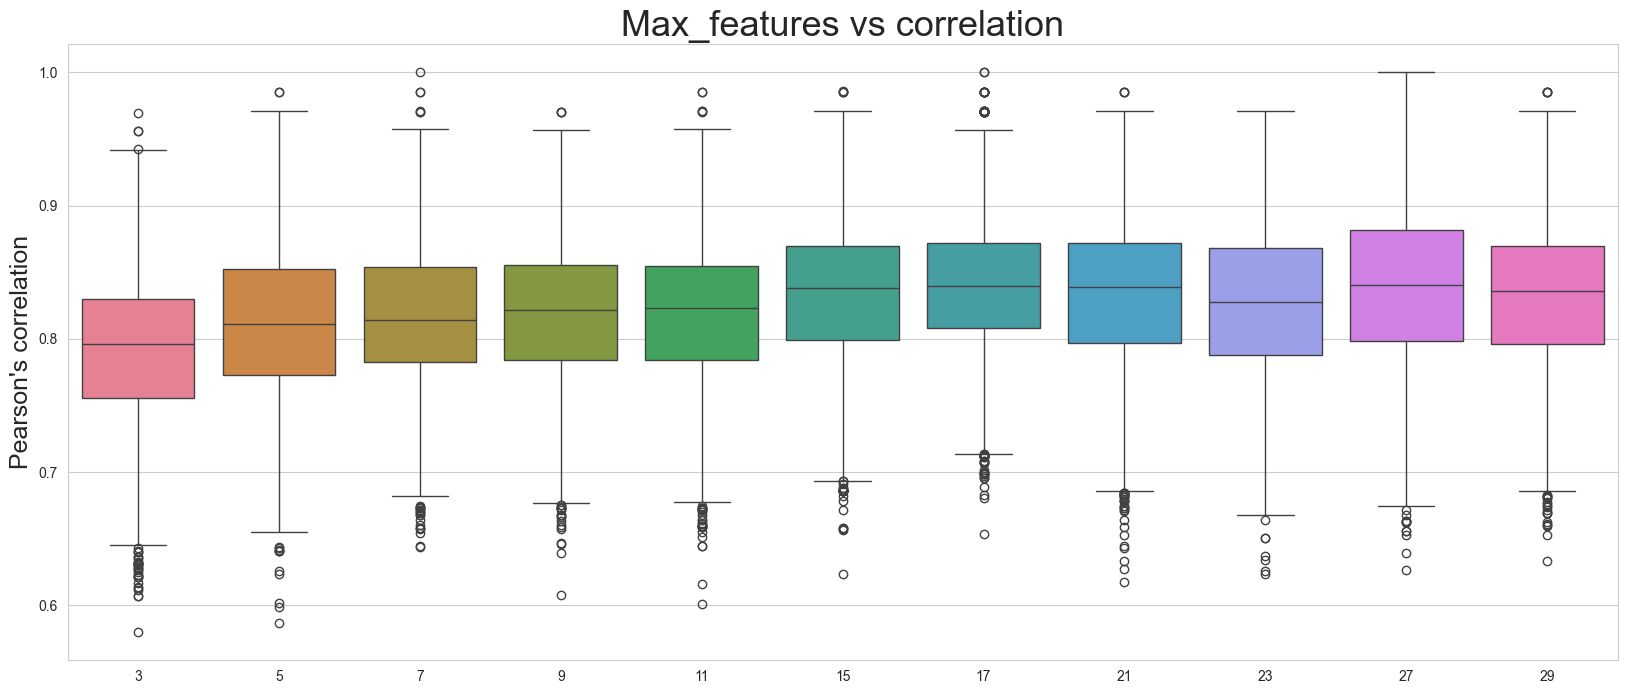

In [23]:
plt.figure(figsize=(20,8))
sns.boxplot(pd.concat(max_features_data, axis=1))
plt.ylabel("Pearson's correlation", size=18)
plt.title("Max_features vs correlation", size=26)
plt.show()

Теперь давайте посмотрим, как на это влияет параметр `max_depth`:

In [24]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [25]:
max_depths= [3,5,7,9,11,15,17]

In [26]:
max_depth_data = []
for max_depth in max_depths:
    clf = RandomForestClassifier(max_features=7, max_depth=max_depth,  n_estimators=100, random_state=SEED)
    clf.fit(X_train, y_train)
    corrs = pd.DataFrame(base_model_pair_correlation(clf, X_test), columns=[f'{max_depth}'])
    max_depth_data.append(corrs)

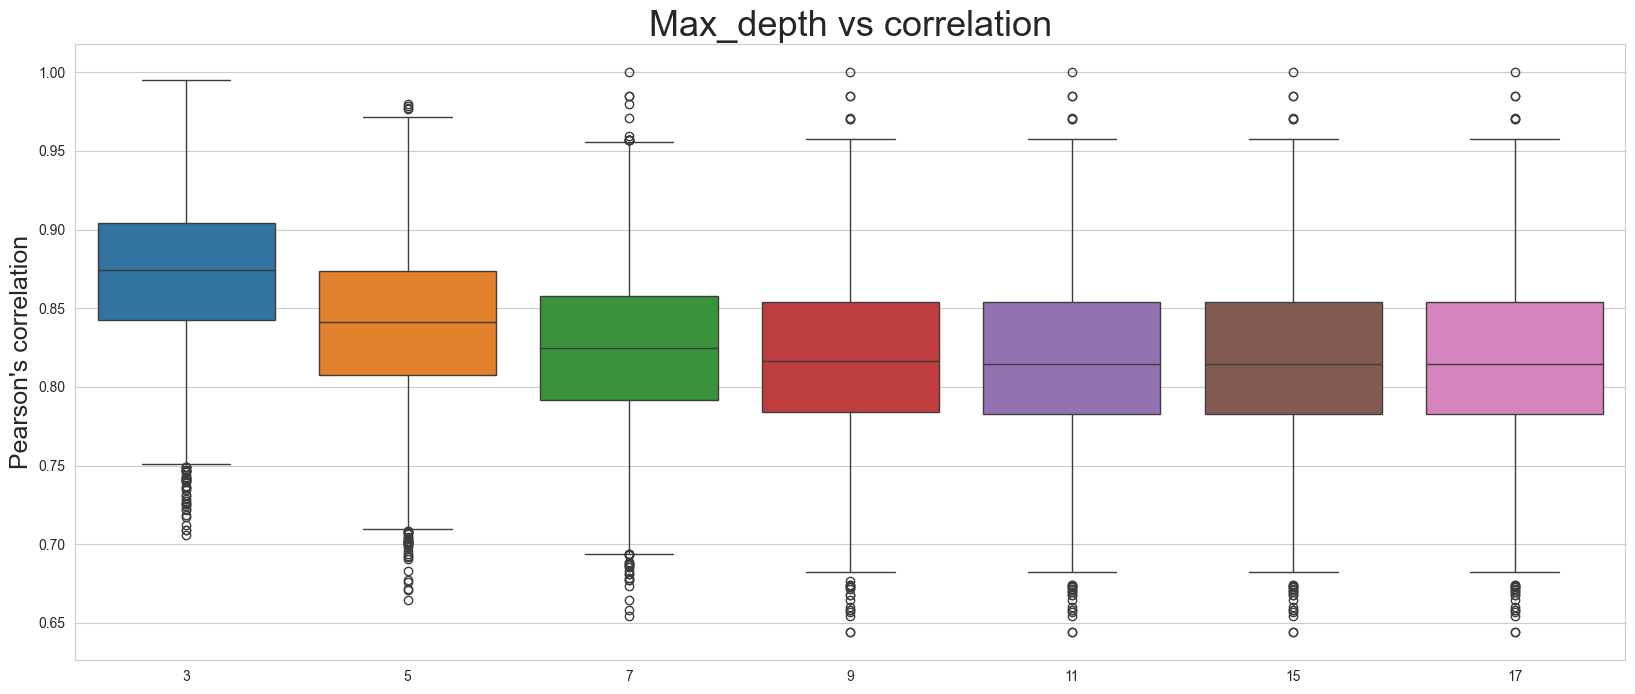

In [27]:
plt.figure(figsize=(20,8))
sns.boxplot(pd.concat(max_depth_data, axis=1))
plt.ylabel("Pearson's correlation", size=18)
plt.title("Max_depth vs correlation", size=26)
plt.show()

Опишите ваши наблюдения:
The results seems to be more or less logical
* An increase in number of features leads to the increase of the median correlation. It is logical, because when we increase the number of feature, we make train each estimator on more similar data than if we would take less features randomly. But if we consider simple combinatorics and assume that than higher the number of combinations, than more possible different models we could fit, then I supposed to have high correlations around very small and very big number, but low correlation in the middle. But here we see a little bit different picture, so the logic of feature selection should be different. Also could be added that very low number of features describes our data in a bad way - there will be lot's of models which may include very low weighted features. Maybe that's why when the max_features is low, the correlation is also low.
* The higher the depth, the more dissimilar estimators we would have, so it is logical that an increase of the depth leads to the descrease of the correlation.

### Задание 3. Строим большой ансамбль

**4 балла + 3 дополнительных за скор выше 0.87**

В данной задаче вам нужно диагностировать сердечное заболевание у людей по медицинским показателям.

In [28]:
#!gdown  --id 1VFbDK-Ad-hpf0_GGCBzn4thdn9mkQ-Y- -O heart.csv -q
heart_dataset = pd.read_csv("../data/heart.csv")

In [29]:
X = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
X_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
178,43,1,0,120,177,0,0,120,1,2.5,1,0,3
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3
201,60,1,0,125,258,0,0,141,1,2.8,1,1,3
246,56,0,0,134,409,0,0,150,1,1.9,1,2,3
153,66,0,2,146,278,0,0,152,0,0.0,1,1,2


Обучите разнообразные классификаторы, приведенные ниже, а также ансамбль `VotingClassifier` из `sklearn.ensemble`, объединяющий эти классификаторы с помощью жесткого или мякого голосования (параметр `voting =` `'hard'` или `'soft'` соответственно). Оцените качество моделей с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`. Часть моделей отсюда мы не проходили, о них можно почитать дополнительно, но в принципе для задания не очень важно знать принципы их работы (но, если есть время, то почитайте, там интересно).

In [30]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
#lgbm = lightgbm.LGBMClassifier(random_state=SEED)
#lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), #("LGBM", lgbm), 
               #("LGBM_RF", lgbm_rf), 
               ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

Здесь могут возникать различные предупреждения при обучении бустингов, не волнуйтесь, все нормально, просто они обычно очень разговорчивые)

In [31]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

voting_hard = VotingClassifier(base_models, voting='hard')
voting_soft = VotingClassifier(base_models, voting='soft')
## END YOUR CODE HERE ##

for model in [dt, rf, cat, etc, knn, svc_lin, svc_rbf, xgb, xgb_rf, lr, nb, voting_hard, voting_soft]: 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"{model.__class__.__name__}: {scores.mean()}")

DecisionTreeClassifier: 0.797997226792219
RandomForestClassifier: 0.8328751280279528
CatBoostClassifier: 0.8342715174922052
ExtraTreesClassifier: 0.8281746031746032
KNeighborsClassifier: 0.6493313763861709
SVC: 0.8403098469098905
SVC: 0.6973119072190279
XGBClassifier: 0.8134522115571786
XGBRFClassifier: 0.8462669018224572
LogisticRegression: 0.8500073681108163
GaussianNB: 0.8140676625250128
VotingClassifier: 0.8375241966705381
VotingClassifier: 0.8405342983656237


In [32]:
voting_soft.fit(X_test, y_test)

VotingClassifier(estimators=[('DT',
                              DecisionTreeClassifier(max_depth=10,
                                                     min_samples_leaf=10,
                                                     random_state=111)),
                             ('RF',
                              RandomForestClassifier(n_estimators=50,
                                                     random_state=111)),
                             ('ETC', ExtraTreesClassifier(random_state=111)),
                             ('KNN', KNeighborsClassifier(weights='distance')),
                             ('SVC_LIN',
                              SVC(kernel='linear', probability=True,
                                  random_state=111)),
                             ('SVC_RBF',
                              SV...
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              objective='binary:logistic',
                                              random_state=111, reg_alpha=None, ...)),
                             ('LR',
                              LogisticRegression(max_iter=10000,
                                                 solver='liblinear')),
                             ('NB', GaussianNB())],
                 voting='soft')

Вы можете заметить, что ансамбль показывает хорошее, но не лучшее качество предсказания, попробуем его улучшить. Как вы знаете, ансамбли работают лучше, когда модели, входящие в них не скоррелированы друг с другом. Определите корреляцию предсказаний базовых моделей в ансамбле на тестовом наборе данных, и удалите из ансамбля те модели, чьи предсказания будут сильнее коррелировать с остальными. Воспользуйтесь функцией `base_model_pair_correlation_for_voting_clf`. **Спойлер**: далеко не факт, что если вы удалите две модели с корреляцией 0.95, то все станет сильно лучше, здесь все будет немного сложнее. Чтобы добиться максимального качества может понадобиться долгий перебор различных комбинаций моделей. Наилучший скор, который мне удалось достичь, это 0.915, но он получен весьма странной комбинацией алгоритмов, а еще и простым перебором всех вариантов)

In [33]:
def base_model_pair_correlation_for_voting_clf(ensemble, X):
    corrs = []
    base_model_names = [f"{est.__class__.__name__}" for est in ensemble.estimators_]
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        if not isinstance(est1, SVC):
            ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t1 = est1.decision_function(Xi_test)


        if not isinstance(est2, SVC):
            ypred_t2 = est2.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t2 = est2.decision_function(Xi_test)
        corrs.append((est1, est2, pearsonr(ypred_t1, ypred_t2)[0]))


    return corrs

In [34]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [35]:
corr_mat = base_model_pair_correlation_for_voting_clf(voting_soft, X_test)

Look at pairs that has correlation higher than 0.95. After several iterations I have understood that this way is not optimal. A decided to try combinations of model in cycle and select those which are close to 0.87 (I used 0.865) and then try to tune them manually.

In [36]:
base_models_corrected = [("DT", dt), 
               ("RF", rf), 
               ("ETC", etc), 
               ("KNN", knn), 
               ("SVC_LIN", svc_lin),
               ("SVC_RBF", svc_rbf), 
               ("CAT", cat), 
               ("XGB", xgb),
               ("XGB_RF", xgb_rf),
               ("LR", lr),
               ("NB", nb)]

In [37]:
#This code takes several minutes to run
scores = []
for i in range(2, 5):
    for comb in combinations(base_models_corrected, i):
        voting_hard = VotingClassifier(list(comb), voting='hard')
        vhs = cross_val_score(voting_hard, X_train, y_train, cv=3, scoring="f1").mean()
        voting_soft = VotingClassifier(list(comb), voting='soft')
        vss = cross_val_score(voting_soft, X_train, y_train, cv=3, scoring="f1").mean()
        #print(vhs, vss)
        if vhs > 0.865 or vss > 0.865:
            scores.append((i, (vhs, vss), comb))
            break

Here is the list ob best scores. Further I will try to tune the best one

In [38]:
scores

[(2,
  (0.8254668013704158, 0.8694543828264759),
  (('CAT', <catboost.core.CatBoostClassifier at 0x13231f160>),
   ('LR', LogisticRegression(max_iter=10000, solver='liblinear')))),
 (3,
  (0.8503228120516498, 0.8656378600823045),
  (('CAT', <catboost.core.CatBoostClassifier at 0x13231f160>),
   ('XGB_RF',
    XGBRFClassifier(base_score=None, booster=None, callbacks=None,
                    colsample_bylevel=None, colsample_bytree=None, device=None,
                    early_stopping_rounds=None, enable_categorical=False,
                    eval_metric=None, feature_types=None, gamma=None,
                    grow_policy=None, importance_type=None,
                    interaction_constraints=None, max_bin=None,
                    max_cat_threshold=None, max_cat_to_onehot=None,
                    max_delta_step=None, max_depth=None, max_leaves=None,
                    min_child_weight=None, missing=nan, monotone_constraints=None,
                    multi_strategy=None, n_estimators

In [39]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
base_models_corrected = [("CAT", cat), ("LR", lr)]

voting_hard_corrected = VotingClassifier(base_models_corrected, voting='hard')
voting_soft_corrected = VotingClassifier(base_models_corrected, voting='soft')
## END YOUR CODE HERE ##

for model in [voting_hard_corrected, voting_soft_corrected]: 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"{model.__class__.__name__}: {scores.mean()}")

VotingClassifier: 0.8254668013704158
VotingClassifier: 0.8694543828264759


Find best parameters for CATboost

In [40]:
depths = [5,7,9,11,13]

for depth in depths:
    cat = catboost.CatBoostClassifier(verbose=0, depth=depth, random_seed=SEED)
    base_models_corrected = [("CAT", cat), ("LR", lr)]
    model = VotingClassifier(base_models_corrected, voting='soft')
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"Depth:{depth}, {model.__class__.__name__}: {scores.mean()}")

Depth:5, VotingClassifier: 0.8658841134334216
Depth:7, VotingClassifier: 0.8743229319988225
Depth:9, VotingClassifier: 0.8743229319988225
Depth:11, VotingClassifier: 0.8707364341085272
Depth:13, VotingClassifier: 0.8707364341085272


Here is the final ensemble with f1 > 0.87

### Задание 4. Определение оттока клиентов из телекома

**6 баллов + 7 дополнительных за высокое качество модели и различные эксперименты**

Будем предсказывать, уйдет ли от нас клиент (переменная `Churn?`). Данные можно скачать [здесь](https://www.kaggle.com/venky12347/churn-telecom). Это будет уже совсем взрослое задание, так как правильного ответа на него нет. Вам нужно будет разобраться с данными, правильно подготовить их для моделей, а также выбрать лучшую модель. 

Задача минимум:

Выберите 2 модели &mdash; один случайный лес и один бустинг из приведенных ниже:

1. `xgboost.XGBClassifier`
2. `xgboost.XGBRFClassifier` &mdash; случайный лес от xgboost
3. `lightgbm.LGBMClassifier`
4. `lightgbm.LGBMClassifier(boosting_type="rf")` &mdash; случайный лес от lightgbm
5. `catboost.CatBoostClassifier`

И попробуйте разобраться с тем, как для этих моделей правильно настраивать гиперпараметры. Советую гуглить примерно следующее `how to choose best hyperparameters for lightgbm`. Там вы найдете кучу сложного и непонятного кода, но если с ним разобраться и научиться обучать нестандартные бустинги, то в плане табличных данных равных вам не будет)

In [41]:
data = pd.read_csv("../data/churn.csv")
data.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


### Firstly check the dimensionality

In [42]:
data.shape

(3333, 21)

In [43]:
data.dtypes

State              object
Account Length      int64
Area Code           int64
Phone              object
Int'l Plan         object
VMail Plan         object
VMail Message       int64
Day Mins          float64
Day Calls           int64
Day Charge        float64
Eve Mins          float64
Eve Calls           int64
Eve Charge        float64
Night Mins        float64
Night Calls         int64
Night Charge      float64
Intl Mins         float64
Intl Calls          int64
Intl Charge       float64
CustServ Calls      int64
Churn?             object
dtype: object

### Check unique values

State: 51
Account Length: 212
Area Code: 3
Phone: 3333
Int'l Plan: 2
VMail Plan: 2
VMail Message: 46
Day Mins: 1667
Day Calls: 119
Day Charge: 1667
Eve Mins: 1611
Eve Calls: 123
Eve Charge: 1440
Night Mins: 1591
Night Calls: 120
Night Charge: 933
Intl Mins: 162
Intl Calls: 21
Intl Charge: 162
CustServ Calls: 10
Churn?: 2


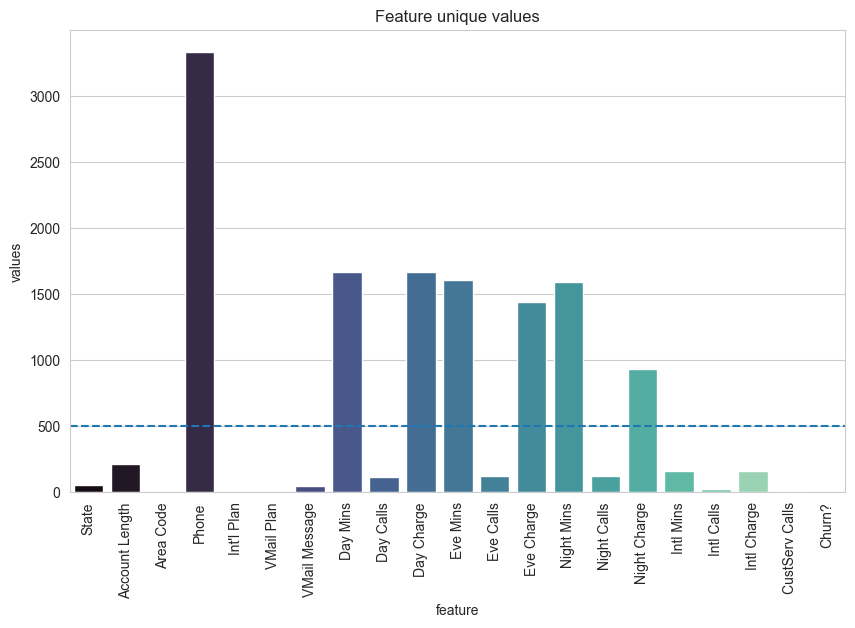

In [44]:
features = []
values = []
for feature in data.columns:
    features.append(feature)
    values.append(len(np.unique(data[feature])))
    print(f"{feature}: {len(np.unique(data[feature]))}")

df = pd.DataFrame({'feature':features, 'values':values})

plt.figure(figsize=(10, 6))
sns.barplot(x='feature', y='values', data=df, hue='feature', palette='mako', legend=False)
plt.title('Feature unique values')
plt.axhline(y=500, linestyle='--')
plt.xticks(rotation=90)
plt.show();

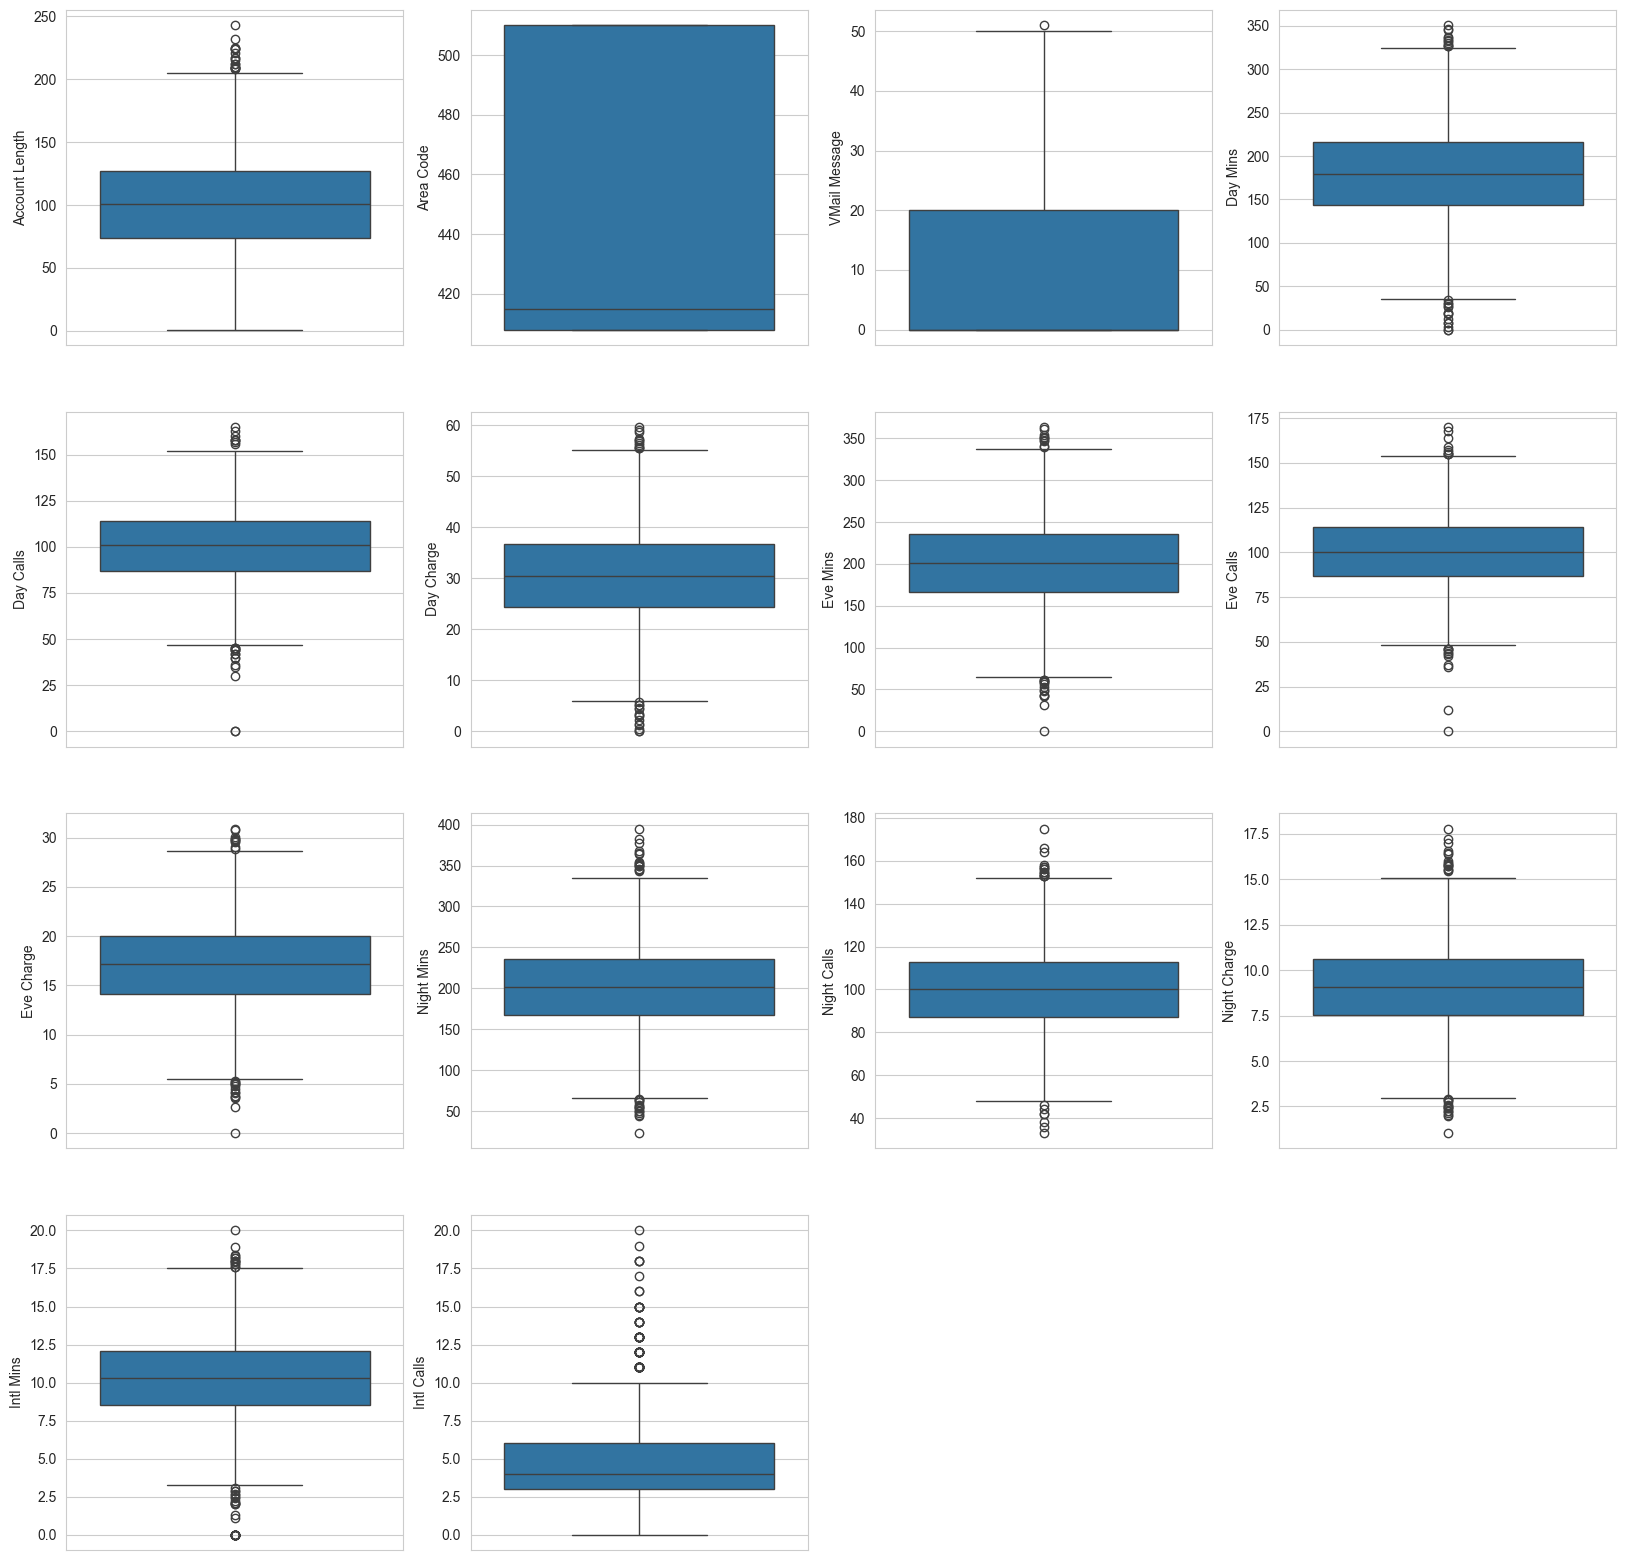

In [45]:
fig = plt.figure(figsize=(20, 20))

for i in range(1, 15):
    fig.add_subplot(4, 4, i)
    sns.boxplot(data[data.select_dtypes(include=np.number).columns[i-1]])
plt.show()

As we know that our dataset consists of 3333 observation, it is not a good idea to use features that have more than 500 values. I have shown on the barplot the threshold line and will drop those features which are over this line. Of course, this is the case only for non-numeric features. So I will totally drop column phone and encode other non-numeric columns

Hm-hm-hm... Some of the features have 0 outliers. Let's see what are these outliers

In [46]:
data[(data['Eve Charge'] == 0) | (data['Eve Mins'] == 0) | (data['Day Mins'] == 0)]

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
1345,SD,98,415,392-2555,no,no,0,0.0,0,0.00,...,130,13.57,167.1,88,7.52,6.8,1,1.84,4,True.
1397,VT,101,510,413-7655,no,no,0,0.0,0,0.00,...,119,16.33,168.8,95,7.60,7.2,4,1.94,1,False.
2932,UT,97,415,418-3181,no,no,0,209.2,134,35.56,...,0,0.00,175.4,94,7.89,11.8,6,3.19,1,False.


Looks like there are 2 people who never talk on phone during the day, but use the phone in the evening and nights, and one person vice versa. These are not outliers - no dropping.

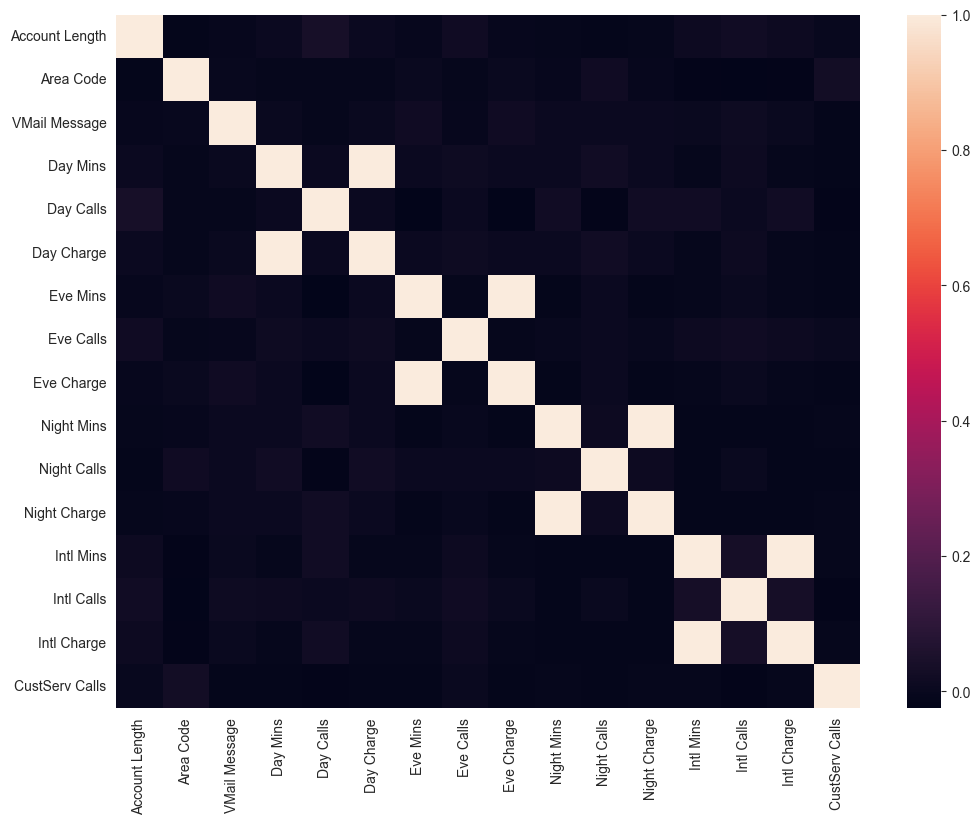

In [47]:
sns.heatmap(data.select_dtypes(include=np.number).corr());

I specially do not show cor values on the plot, because it is could be seen that there are no correlated values except those, which actually represent almost the same and have cor value aroun 1.0 (mins - charge). I will drop either mins or charge columns.

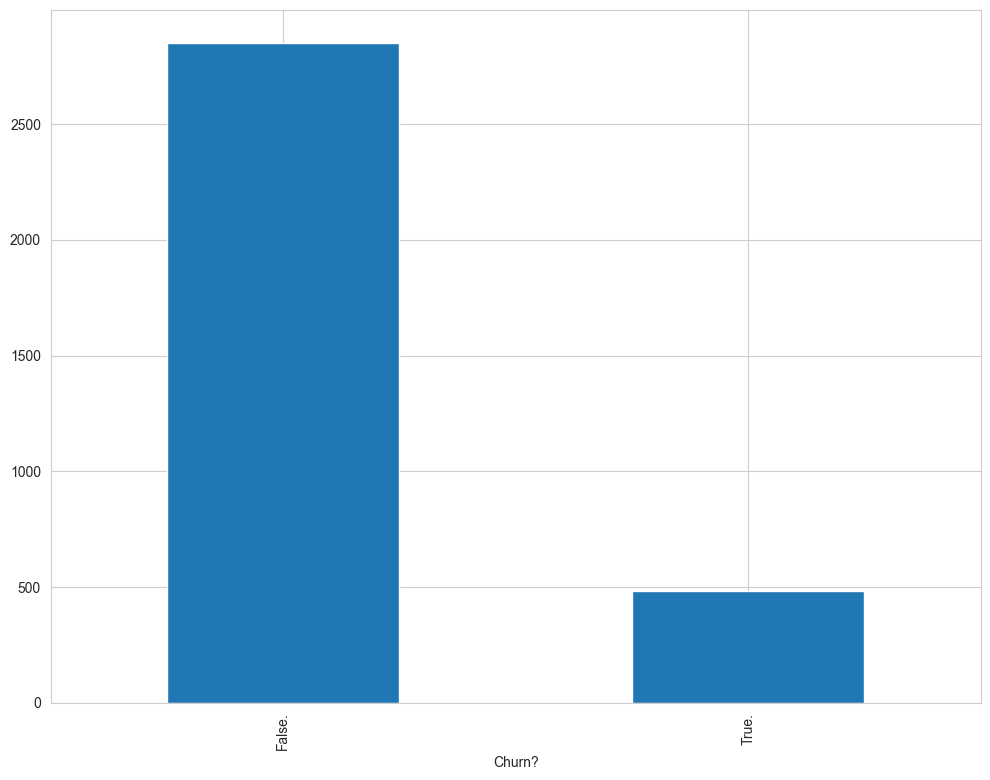

In [48]:
data['Churn?'].value_counts().plot(kind = 'bar');

Actually, classes are unbalances. I will use stratify argument for test-train split and I could use weights for RandomForest/boosting.

In [49]:
X = data.drop(columns=['Phone', 'Day Mins', 'Eve Mins', 'Night Mins', 'Churn?'])
y = data[['Churn?']]

I will also replace yes no to 1 0 for better performance, but for trees it is not necessary

In [50]:
X.replace(('yes', 'no'), (1, 0), inplace=True)
y.replace(('True.', 'False.'), (1,0), inplace=True)

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2,
                                                    stratify = y, 
                                                    random_state=SEED)

I clearly don't like the idea to use one hot encoder here for State feature, but honestly, I do this work already after deadline and I'm very tires, so sorry for this, but I shall not, but will use OHE. 

Pupupu... I got very bad model performance. I tried class_weight, but it didn't help very much. I will delete non-numeric columns finally


In [52]:
X = data.drop(columns=['Phone', 'Day Mins', 'Eve Mins', 'Night Mins', 'Churn?', 'State'])
y = data[['Churn?']]

In [53]:
X.replace(('yes', 'no'), (1, 0), inplace=True)
y.replace(('True.', 'False.'), (1,0), inplace=True)

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2,
                                                    stratify = y, 
                                                    random_state=SEED)

#### XGB-RF

In [55]:
param_grid = {
    'max_depth': [5, 7, 9, 11],
    'n_estimators': [50, 100, 200, 500],
}

xgbrf_model = xgboost.XGBRFClassifier()

grid_search_xgbrf = GridSearchCV(estimator=xgbrf_model, param_grid=param_grid, cv=5)
grid_search_xgbrf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRFClassifier(base_score=None, booster=None,
                                       callbacks=None, colsample_bylevel=None,
                                       colsample_bytree=None, device=None,
                                       early_stopping_rounds=None,
                                       enable_categorical=False,
                                       eval_metric=None, feature_types=None,
                                       gamma=None, grow_policy=None,
                                       importance_type=None,
                                       interaction_constraints=None,
                                       max_bin=None, max_cat_threshold=None,
                                       max_cat_to_onehot=None,
                                       max_delta_step=None, max_depth=None,
                                       max_leaves=None, min_child_weight=None,
                                       missing=nan, monotone_constraints=None,
                                       multi_strategy=None, n_estimators=None,
                                       n_jobs=None, num_parallel_tree=None,
                                       objective='binary:logistic',
                                       random_state=None, reg_alpha=None, ...),
             param_grid={'max_depth': [5, 7, 9, 11],
                         'n_estimators': [50, 100, 200, 500]})

In [56]:
grid_search_xgbrf.best_params_

{'max_depth': 11, 'n_estimators': 500}

In [57]:
xgbrf_model = xgboost.XGBRFClassifier(n_estimators = 500, max_depth = 9)

In [58]:
xgbrf_model.fit(X_train, y_train)

XGBRFClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bytree=None, device=None,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, feature_types=None, gamma=None,
                grow_policy=None, importance_type=None,
                interaction_constraints=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=9, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=500, n_jobs=None,
                num_parallel_tree=None, objective='binary:logistic',
                random_state=None, reg_alpha=None, ...)

In [59]:
y_pred = xgbrf_model.predict(X_test)

In [60]:
# Create ROC-curve and output the confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

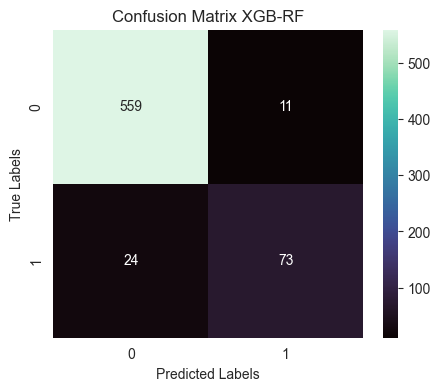

In [61]:
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap='mako', cbar=True)
plt.title("Confusion Matrix XGB-RF")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [62]:
print(f'Accuracy: {round(accuracy_score(y_test, y_pred), 2)}, Precision: {round(precision_score(y_test, y_pred), 2)}, Recall: {round(recall_score(y_test, y_pred), 2)}, F1: {round(f1_score(y_test, y_pred), 2)}')

Accuracy: 0.95, Precision: 0.87, Recall: 0.75, F1: 0.81


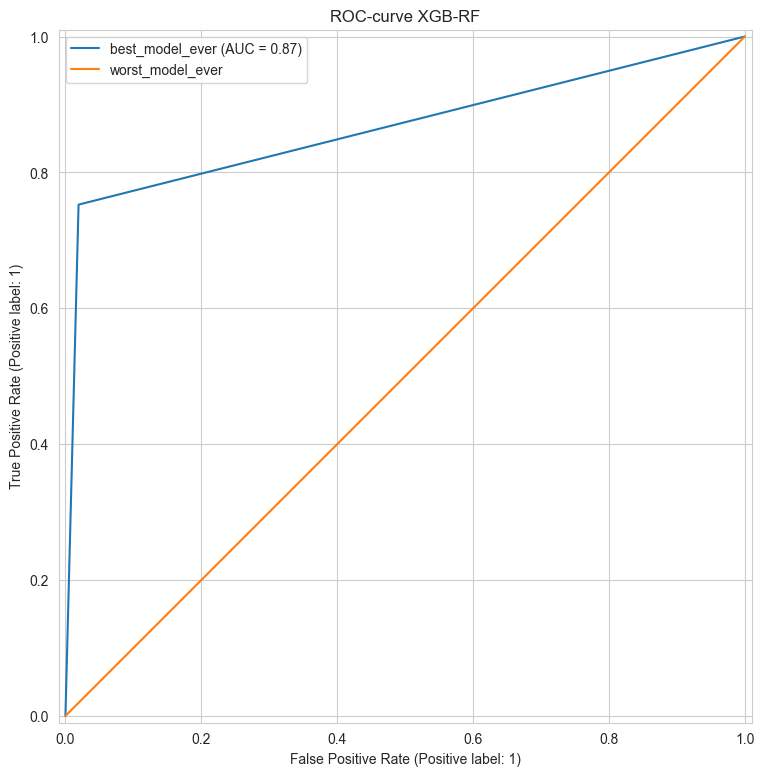

In [63]:
RocCurveDisplay.from_predictions(y_test, y_pred, name="best_model_ever")
plt.plot([0, 1], [0, 1], label="worst_model_ever")
plt.title('ROC-curve XGB-RF')
plt.legend();

#### XGB

In [64]:
param_grid = {
    'max_depth': [5, 7, 9, 11],
    'n_estimators': [50, 100, 200, 500],
}

xgb_model = xgboost.XGBClassifier()

grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5)
grid_search_xgb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'max_depth': [5, 7, 9, 11],
                         'n_estimators': [50, 100, 200, 500]})

In [65]:
grid_search_xgbrf.best_params_

{'max_depth': 11, 'n_estimators': 500}

In [82]:
xgb_model = xgboost.XGBClassifier(max_depth = 11, n_estimators = 500)

In [83]:
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=11, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [84]:
y_pred = xgb_model.predict(X_test)

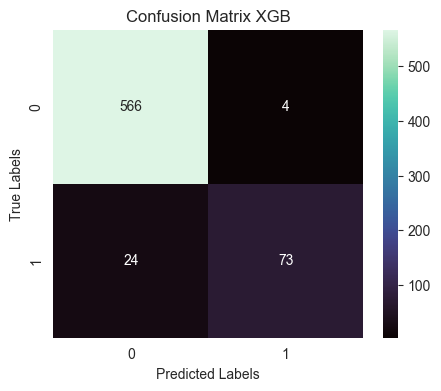

In [85]:
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap='mako', cbar=True)
plt.title("Confusion Matrix XGB")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [70]:
print(f'Accuracy: {round(accuracy_score(y_test, y_pred), 2)}, Precision: {round(precision_score(y_test, y_pred), 2)}, Recall: {round(recall_score(y_test, y_pred), 2)}, F1: {round(f1_score(y_test, y_pred), 2)}')

Accuracy: 0.96, Precision: 0.95, Recall: 0.75, F1: 0.84


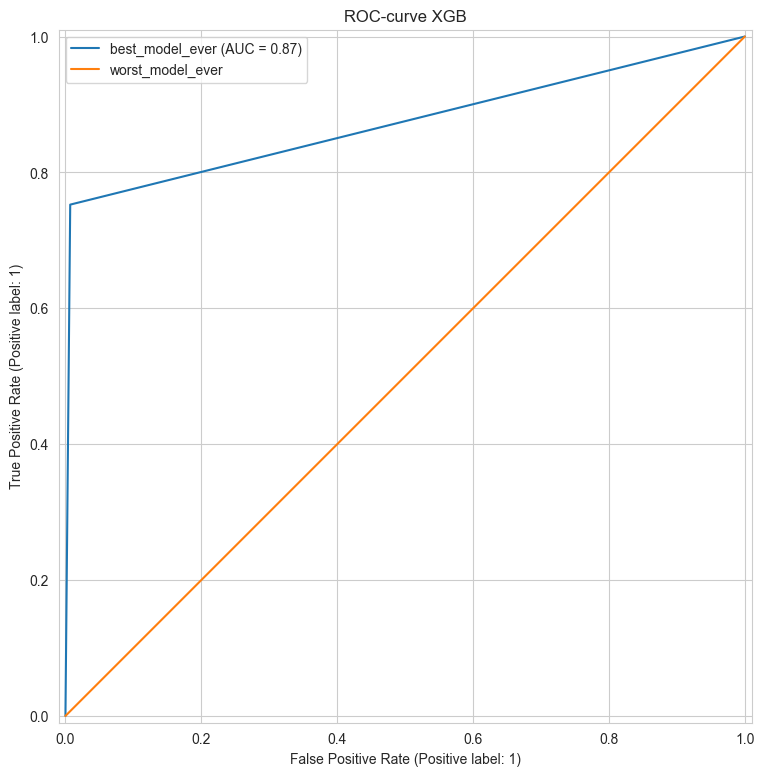

In [71]:
RocCurveDisplay.from_predictions(y_test, y_pred, name="best_model_ever")
plt.plot([0, 1], [0, 1], label="worst_model_ever")
plt.title('ROC-curve XGB')
plt.legend();

The results are more or less the same for both performance, according to metrics and confusion matrix. And metrics are significantly better than before, when I tried to perform one hot encoding for Stats feature with a lot of unique values. So here I clearly understood that OHE is not the best way for features with a lot of unique values. 

### Задание 5. Рисуем

**дополнительно 0.5 балла**

Наверняка, в процессе выполнения этого задания вас переполняли какие-то эмоции. Нарисуйте что-то, что бы могло бы передать их (я сам не умею, так что, если это будет просто квадрат, тоже подойдет). Прикрепите сюда свой рисунок:

In [72]:
## PASTE YOUR MASTERPIECE HERE (/¯◡ ‿ ◡)/¯☆*##

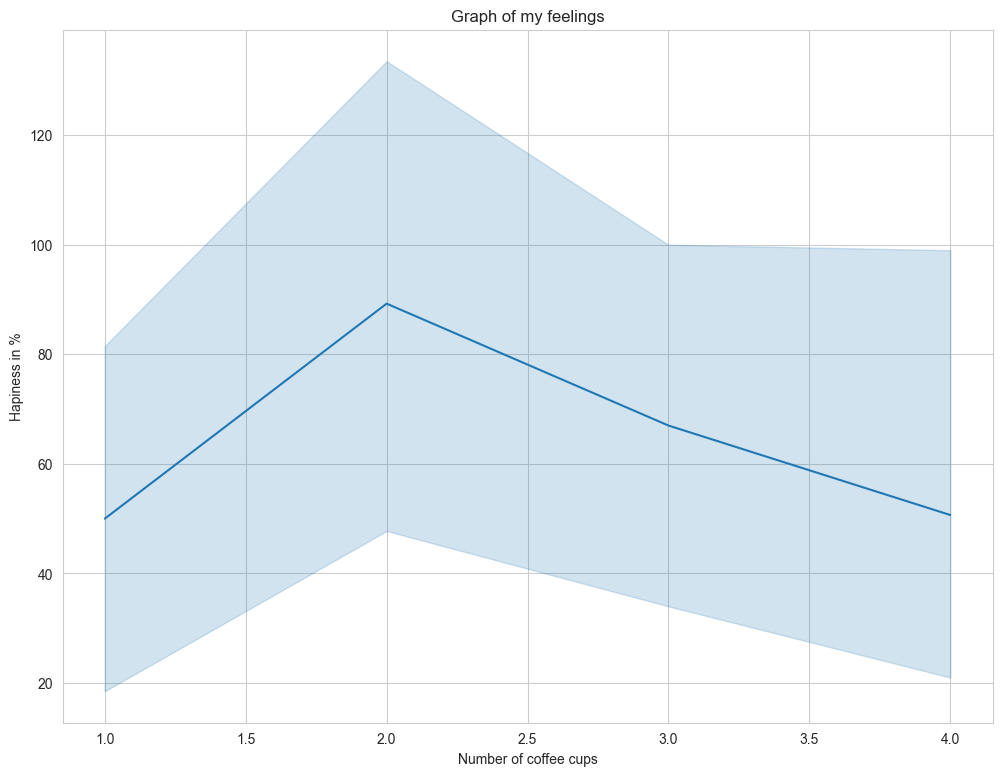

In [73]:
sns.lineplot(x=[1,2,4,2,3,4,2,1,1,4,2,1,3], y = [5,34,21,89,34,32,150,87,76,99,84,32,100])
plt.title('Graph of my feelings')
plt.ylabel('Hapiness in %')
plt.xlabel('Number of coffee cups');

### Therapy time

Напишите здесь ваши впечатления о задании (можно и не о задании): было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**

К сожалению, меня подвела моя командировка по дипломной работе. После 4 дней в Новосибирске и сингл-селла накопилось много долгов, поэтому приходится сдавать ДЗ после дедлайна. Если вдруг вы решите не снимать мне баллы за пропуск дедлайна, я буду очень рад, но не сильно расстроюсь, если снизите. Задание очень интересно. К сожалению, не хватило времени сделать его глубже (лучше разобраться с xgboost, lightgbm). Перебор параметров иногда занимал слишком много времени, поэтому приходилось его делать более простым, чем хотелось бы.